<a href="https://colab.research.google.com/github/sayantika21175/RAG_Projects/blob/main/Semantic%2Bkeyword_with_UI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installing the required Libraries


In [1]:
# !pip install langchain faiss-cpu rank_bm25 sentence-transformers
# !pip install -U langchain-community

#Import the required packages

In [2]:
import pandas as pd
import os
from sentence_transformers import SentenceTransformer
from langchain.vectorstores import FAISS
import string
import faiss
import re
import numpy as np
import gradio as gr

#Load the dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
data = pd.read_csv(r'/content/drive/MyDrive/capstone_lumen/data.csv',encoding='ISO-8859-1')
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


#Dataset Understanding and Preprocessing
** Here we need the column Description from the dataset

In [5]:
#get the unique customer_id
customer_id = data['CustomerID'].unique()

In [6]:
len(customer_id)

4373

In [7]:
data.shape

(541909, 8)

In [8]:
#check if Description has some dublicates or not
data['Description'].value_counts()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2369
REGENCY CAKESTAND 3 TIER,2200
JUMBO BAG RED RETROSPOT,2159
PARTY BUNTING,1727
LUNCH BAG RED RETROSPOT,1638
...,...
ANT SILVER TURQUOISE BOUDICCA RING,1
Damages,1
Found by jackie,1


In [9]:
#check if data has some dublicate rows
data.duplicated().sum()

np.int64(5268)

In [10]:
data.drop_duplicates(inplace=True)#Dropping the duplicates values

#Check if in the column Description contains any non string value or not

In [11]:
non_string_mask = data['Description'].apply(lambda x: not isinstance(x, str))
non_string_values = data[non_string_mask]
print(non_string_values)


       InvoiceNo StockCode Description  Quantity      InvoiceDate  UnitPrice  \
622       536414     22139         NaN        56  12/1/2010 11:52        0.0   
1970      536545     21134         NaN         1  12/1/2010 14:32        0.0   
1971      536546     22145         NaN         1  12/1/2010 14:33        0.0   
1972      536547     37509         NaN         1  12/1/2010 14:33        0.0   
1987      536549    85226A         NaN         1  12/1/2010 14:34        0.0   
...          ...       ...         ...       ...              ...        ...   
535322    581199     84581         NaN        -2  12/7/2011 18:26        0.0   
535326    581203     23406         NaN        15  12/7/2011 18:31        0.0   
535332    581209     21620         NaN         6  12/7/2011 18:35        0.0   
536981    581234     72817         NaN        27  12/8/2011 10:33        0.0   
538554    581408     85175         NaN        20  12/8/2011 14:06        0.0   

        CustomerID         Country  
62

#Remove the NaN values from the column Description

In [12]:
#remove the Nan Value
data.dropna(inplace=True)

In [13]:
data.duplicated().sum()

np.int64(0)

In [14]:
non_string_mask= data['Description'].apply(lambda x: not isinstance(x,str))
non_string_values = data[non_string_mask]
print(non_string_values)

Empty DataFrame
Columns: [InvoiceNo, StockCode, Description, Quantity, InvoiceDate, UnitPrice, CustomerID, Country]
Index: []


#Considered only the column Description from the data and created a new data named dataset

In [15]:
dataset=data['Description'].reset_index(drop=True)
dataset.head()

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


In [16]:
dataset.value_counts()

,count
Description,
WHITE HANGING HEART T-LIGHT HOLDER,2058
REGENCY CAKESTAND 3 TIER,1894
JUMBO BAG RED RETROSPOT,1659
PARTY BUNTING,1409
ASSORTED COLOUR BIRD ORNAMENT,1405
...,...
"LETTER ""W"" BLING KEY RING",1
CROCHET LILAC/RED BEAR KEYRING,1
MIDNIGHT BLUE CRYSTAL DROP EARRINGS,1


#Checked the number of unique values of the Description column

In [17]:
len(dataset.unique())

3896

#Dropped the duplicates values or duplicate Descriptions from the dataset

In [18]:
dataset_modified=dataset.drop_duplicates().reset_index(drop=True)
dataset_modified.head()

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


In [19]:
dataset_modified.shape

(3896,)

#Dataset Preprocessing
 * Remove the whitespaces
 * Remove the tabs,newlines
 * Remove the punctuations (?,@,!,#)

In [20]:
import re

def fix_hyphenated_line_breaks(text):
    return re.sub(r'(\w+)-\n(\w+)', r'\1\2', text)

def clean_whitespace(text):
    text = re.sub(r'\s+', ' ', text)    # Replace multiple whitespace (including newlines, tabs) with single space
    text = re.sub(r'[?!#@]', '', text)  # Replace specific characters with empty string
    return text.strip()

In [21]:
dataset_modified_1 = dataset_modified.apply(fix_hyphenated_line_breaks)
dataset_modified_1.head()

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


In [22]:
dataset_modified_1 = dataset_modified_1.apply(clean_whitespace)
dataset_modified_1.head()

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


In [23]:
dataset_modified_1.shape

(3896,)

In [24]:
dataset_modified_1.head()

,Description
0,WHITE HANGING HEART T-LIGHT HOLDER
1,WHITE METAL LANTERN
2,CREAM CUPID HEARTS COAT HANGER
3,KNITTED UNION FLAG HOT WATER BOTTLE
4,RED WOOLLY HOTTIE WHITE HEART.


#Load the embedding model 'all-MiniLM-L6-v2' from sentence-transformer
 * Output embedding size is 384

In [25]:
embed_model=SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Generated the embeddings of the dataset or each rows of the dataset or the Descriptions
* it has rows = 3896
* each output embedding size is 384
* Hence the output matrix shape is [3896,384]
* Here batch size = 32 we have considered.
* In one batch 32 rows are getting embedded. So no of batches 3896/32 = 122

In [26]:
embeddings=embed_model.encode(dataset_modified_1,batch_size=32,show_progress_bar=True,convert_to_tensor=True)

Batches:   0%|          | 0/122 [00:00<?, ?it/s]

In [27]:
embeddings.shape

torch.Size([3896, 384])

# Created a function which will normalize the embeddings
* this will help to have the cosine similarity between two embedding vectors.
* Cosine similarity between two vectors A and B is:
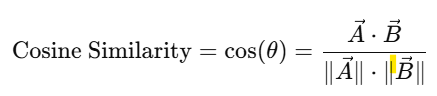


* A.B is the dot product of the vectors
* ||A|| and ||B|| are the magnitudes of the vectors
* The similarity value 1 ->  Vectors point in the same direction (perfectly similar)
* The similarity value 0 -> Vectors are orthogonal (completely dissimilar)

In [28]:
def normalise_vector(vecs):
  norms = np.linalg.norm(vecs, axis=-1, keepdims=True)
  return vecs / norms

# creating the list of the rows of the dataset. This list contains all the descriptions.

In [29]:
texts= dataset_modified_1.tolist()

# Normalize the embeddings

In [30]:
normalize_embeddings=normalise_vector(np.array(embeddings)).astype('float32')

In [31]:
normalize_embeddings.shape

(3896, 384)

# Creating the Faiss Index using the inner product (Cosine similarity of normalise vectors)

In [33]:
index_faiss=faiss.IndexFlatIP(normalize_embeddings.shape[1])
index_faiss.add(normalize_embeddings)

# Store the Index into the disk

In [34]:
faiss.write_index(index_faiss,"/content/drive/MyDrive/capstone_lumen/faiss_index.faiss")

# Read the Index from the Disk

In [35]:
faiss_index=faiss.read_index("/content/drive/MyDrive/capstone_lumen/faiss_index.faiss")   # read the index from the disk

# Ask Query → Convert Query to Embedding → Search in Vector Database (Faiss Index) → Retrieve Top-k Relevant Vectors/Documents
* Similarity is measured using cosine similarity, so a higher score indicates that the document is more similar to the query.

In [36]:
Query1='LETTER "W" BLING KEY RING'
embed_query1=embed_model.encode([Query1])
k=5
distances,indices=faiss_index.search(embed_query1,k)
print(f"Nearest intem indices:",indices)
print(f"Nearest item distances:",distances)

Nearest intem indices: [[3891 3263 3261 1901 2787]]
Nearest item distances: [[1.         0.8369267  0.83217824 0.83146894 0.8251783 ]]


In [37]:
indices= indices.flatten().tolist()
for i in indices:
  print(dataset_modified_1[i])

LETTER "W" BLING KEY RING
LETTER "H" BLING KEY RING
LETTER "L" BLING KEY RING
LETTER "B" BLING KEY RING
LETTER "A" BLING KEY RING


In [38]:
#query2="Keychain with Alphabet 'W' in Bling Style"
query2="colourful heart-shaped hanging light holder"
#query2="holder"
embed_query2=embed_model.encode([query2])
k=4
distances_q2,indices_q2=faiss_index.search(embed_query2,k)
# print(f"Nearest item indices for query 2:",indices_q2)
# print(f"Nearest item distances for query2:",distances_q2)
indices_q2= indices_q2.flatten().tolist()
for i in indices_q2:
  print(dataset_modified_1[i])

WHITE HANGING HEART T-LIGHT HOLDER
PINK HANGING HEART T-LIGHT HOLDER
RED HANGING HEART T-LIGHT HOLDER
CREAM HANGING HEART T-LIGHT HOLDER


# Calculated the Precision and Recall
* Precision = Of the items recommended, how many are actually relevant?
        --  [TP/ (TP+FP)] ; TP = True Positives, FP = False Positives
* Recall = Of all relevant items, how many were actually recommended?
        -- [TP / (TP+FN)] ; FN = False Negatives
* In recommender systems, high precision means recommendations are usually relevant, and high recall means most relevant items are being recommended.
* Since we are selecting the top-k results, increasing the value of k can improve both precision and recall — particularly when the number of ground truth relevant items exceeds k.

In [39]:
retrieved_set=set(indices_q2)
#retrieved_indices
relevant_set=set([3894,0,58,3759])# in the dataset only 4 are relevant items or ground truth
true_positives = retrieved_set & relevant_set

precision = len(true_positives) / len(retrieved_set)
recall = len(true_positives) / len(relevant_set)

print(f"Precision@4: {precision:.2f}")
print(f"Recall@4: {recall:.2f}")

Precision@4: 1.00
Recall@4: 1.00


# Here we have selected k=24 because in our dataset total 24 are ground truth values for the below query.
** So for k=24 the Precision and Recall are the highest = 0.83

In [40]:
query4="Keychain with alphabet"
embed_query4=embed_model.encode([query4])
k=24
distances_q4,indices_q4=faiss_index.search(embed_query4,k)
# print(f"Nearest item indices for query 4:",indices_q4)
# print(f"Nearest item distances for query4:",distances_q4)
indices_q4= indices_q4.flatten().tolist()
for i in indices_q4:
  print(dataset_modified_1[i])

WRAP ALPHABET DESIGN
ALPHABET STENCIL CRAFT
LETTER "A" BLING KEY RING
LETTER "N" BLING KEY RING
LETTER "C" BLING KEY RING
LETTER "S" BLING KEY RING
LETTER "K" BLING KEY RING
LETTER "L" BLING KEY RING
LETTER "H" BLING KEY RING
TRADTIONAL ALPHABET STAMP SET
LETTER "Z" BLING KEY RING
LETTER "I" BLING KEY RING
LETTER "U" BLING KEY RING
LETTER "D" BLING KEY RING
LETTER "F" BLING KEY RING
LETTER "Y" BLING KEY RING
LETTER "J" BLING KEY RING
LETTER "O" BLING KEY RING
LETTER "W" BLING KEY RING
LETTER "T" BLING KEY RING
LETTER "B" BLING KEY RING
LETTER "E" BLING KEY RING
DINOSAUR KEYRINGS ASSORTED
LETTER "G" BLING KEY RING


** Relevant items in our dataset for the above query4="Keychain with alphabet"

In [41]:
query4_relevant_index=[906,907,908,909,1900,1901,1902,2402,2593,2619,2787,2849,3174,3240,3261,3262,3263,3421,3887,3888,3889,3890,3891,3892]


retrieved_set_q4=set(indices_q4)
relevant_set_q4=set(query4_relevant_index)
true_positives_q4 = retrieved_set_q4 & relevant_set_q4

precision_q4 = len(true_positives_q4) / len(retrieved_set_q4)
recall_q4 = len(true_positives_q4) / len(relevant_set_q4)

print(f"Precision@24: {precision_q4:.2f}")
print(f"Recall@24: {recall_q4:.2f}")

Precision@24: 0.83
Recall@24: 0.83


# Check Precision and Recall when K=5 and get the precision = 0.60 and Recall = 0.12

In [42]:
query4="Keychain with alphabet"
embed_query4=embed_model.encode([query4])
k=5
distances_q4,indices_q4=faiss_index.search(embed_query4,k)
# print(f"Nearest item indices for query 4:",indices_q4)
# print(f"Nearest item distances for query4:",distances_q4)
indices_q4= indices_q4.flatten().tolist()
for i in indices_q4:
  print(dataset_modified_1[i])

WRAP ALPHABET DESIGN
ALPHABET STENCIL CRAFT
LETTER "A" BLING KEY RING
LETTER "N" BLING KEY RING
LETTER "C" BLING KEY RING


In [43]:
retrieved_set_q4=set(indices_q4)
relevant_set_q4=set(query4_relevant_index)
true_positives_q4 = retrieved_set_q4 & relevant_set_q4

precision_q4 = len(true_positives_q4) / len(retrieved_set_q4)
recall_q4 = len(true_positives_q4) / len(relevant_set_q4)

print(f"Precision@4: {precision_q4:.2f}")
print(f"Recall@4: {recall_q4:.2f}")

Precision@4: 0.60
Recall@4: 0.12


# BM25 Or Keyword Search
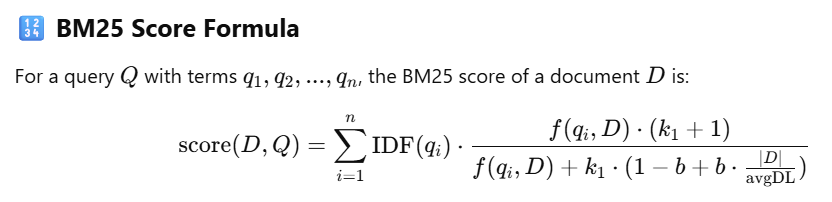

** Tokenize each sentence or descriptions

In [44]:
import nltk
nltk.download('punkt')
print(nltk.data.find("tokenizers/punkt"))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/root/nltk_data/tokenizers/punkt


In [46]:
from rank_bm25 import BM25Okapi
#nltk.data.path.append(r"C:/Users/sayantika.chatterjee/AppData/Roaming/nltk_data")
nltk.download('punkt_tab')

from nltk.tokenize import word_tokenize
tokenized_output = [word_tokenize(t.lower()) for t in texts]
bm25 = BM25Okapi(tokenized_output)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [48]:
tokenized_output[0]

['white', 'hanging', 'heart', 't-light', 'holder']

In [51]:
bm25.corpus_size

3896

In [57]:
bm25.get_scores(tokenized_output[0])

array([15.99592257,  3.93991845,  0.        , ...,  0.        ,
       12.81357189,  0.        ])

# Get the score of the Query using BM25

In [58]:
query="Keychain with alphabet"
tokenized_query=word_tokenize(query.lower())
bm25_scores=bm25.get_scores(tokenized_query)
bm25_scores

array([0., 0., 0., ..., 0., 0., 0.])

In [59]:
top_n = np.argsort(bm25_scores)[::-1][:24]
for idx in top_n:
    print(f"Score: {bm25_scores[idx]:.4f} | Doc: {texts[idx]}")

Score: 6.4563 | Doc: ALPHABET STENCIL CRAFT
Score: 6.4563 | Doc: JUMBO BAG ALPHABET
Score: 6.4563 | Doc: WRAP ALPHABET DESIGN
Score: 6.4563 | Doc: WRAP ALPHABET POSTER
Score: 5.7695 | Doc: ALPHABET HEARTS STICKER SHEET
Score: 5.7695 | Doc: TRADTIONAL ALPHABET STAMP SET
Score: 5.7695 | Doc: CHARLOTTE BAG ALPHABET DESIGN
Score: 5.7695 | Doc: CHARLOTTE BAG VINTAGE ALPHABET
Score: 5.7695 | Doc: LUNCH BAG ALPHABET DESIGN
Score: 5.2148 | Doc: BOYS ALPHABET IRON ON PATCHES
Score: 5.2148 | Doc: BOX OF VINTAGE ALPHABET BLOCKS
Score: 5.2148 | Doc: 70'S ALPHABET WALL ART
Score: 5.2148 | Doc: WALL ART 70'S ALPHABET
Score: 5.2148 | Doc: GIRLS ALPHABET IRON ON PATCHES
Score: 4.7575 | Doc: BUNDLE OF 3 ALPHABET EXERCISE BOOKS
Score: 4.0443 | Doc: HEART DECORATION WITH PEARLS
Score: 4.0443 | Doc: BROCANTE SHELF WITH HOOKS
Score: 4.0443 | Doc: FILIGRIS HEART WITH BUTTERFLY
Score: 4.0443 | Doc: JIGSAW TREE WITH BIRDHOUSE
Score: 4.0443 | Doc: HANGING HEART WITH BELL
Score: 4.0443 | Doc: UTILTY CABINET WIT

In [60]:
top_n

array([ 979, 2956, 2537, 3437, 1603, 3808, 2961, 2955, 2957, 2685,   16,
       3691, 3715, 2684, 3120, 1508, 1021, 1059, 1617, 2732, 1612, 1959,
       1428, 3403])

# Calculate the Precision and Recall of the Retrieved Results(Using BM25)

In [61]:
retrieved_set_q4=set(top_n)
relevant_set_q4=set(query4_relevant_index)
true_positives_q4 = retrieved_set_q4 & relevant_set_q4

precision_q4 = len(true_positives_q4) / len(retrieved_set_q4)
recall_q4 = len(true_positives_q4) / len(relevant_set_q4)

print(f"Precision: {precision_q4:.2f}")
print(f"Recall: {recall_q4:.2f}")

Precision: 0.00
Recall: 0.00


In [ ]:
from datetime import datetime

In [ ]:
start_time = datetime.now()
query3="holder"
tokenized_query3=word_tokenize(query3.lower())
bm25_scores_3=bm25.get_scores(tokenized_query3)
top_n = np.argsort(bm25_scores_3)[::-1][:3]
end_time = datetime.now()
for idx in top_n:
    print(f"Score: {bm25_scores_3[idx]:.4f} | Doc: {texts[idx]}")
print(f"total time taken for keyword search {end_time-start_time}")

Score: 4.6172 | Doc: POPCORN HOLDER
Score: 4.0676 | Doc: SMALL POPCORN HOLDER
Score: 4.0676 | Doc: LARGE POPCORN HOLDER
total time taken for keyword search 0:00:00.002746


In [ ]:
dataset_modified_1.to_csv('/content/drive/MyDrive/capstone_lumen/dataset_modified.csv')

In [ ]:
start_time= datetime.now()
query4="holder"
embed_query4=embed_model.encode([query4])
k=3
distances_q4,indices_q4=faiss_index.search(embed_query4,k)
end_time=datetime.now()
print(f"total time taken for vector search {end_time-start_time}")
# print(f"Nearest item indices for query 4:",indices_q4)
# print(f"Nearest item distances for query4:",distances_q4)
indices_q4= indices_q4.flatten().tolist()
for i in indices_q4:
  print(dataset_modified_1[i])

total time taken for vector search 0:00:00.023755
POPCORN HOLDER
RED STAR CARD HOLDER
FRENCH ENAMEL UTENSIL HOLDER


In [70]:
def search_result(query, top_k=5):
    # Semantic Search
    query_embedding = embed_model.encode([query])
    distances, indices = faiss_index.search(query_embedding, top_k)
    indices = indices.flatten().tolist()
    semantic_outcome = [dataset_modified_1[i] for i in indices]

    # Keyword Search using BM25
    tokenized_query = word_tokenize(query.lower())
    bm25_scores = bm25.get_scores(tokenized_query)
    keyword_indices = np.argsort(bm25_scores)[::-1][:top_k]
    keyword_search_outcome = [dataset_modified_1[i] for i in keyword_indices]

    # Build HTML with <br> for line breaks
    semantic_html = "<br>".join([f"- {r}" for r in semantic_outcome])
    keyword_html = "<br>".join([f"- {r}" for r in keyword_search_outcome])

    results = f"""
        <h3 style='color:#1f77b4;'>🔍 Semantic Search Results</h3>
        {semantic_html}
        <br><br>
        <h3 style='color:#2ca02c;'>📚 Keyword Search Results (BM25)</h3>
        {keyword_html}
    """

    return results

In [71]:
with gr.Blocks(title="E-Commerce Search Engine") as demo:
    gr.Markdown("## 🛍️ Semantic vs Keyword Search Demo")

    query_input = gr.Textbox(label="Enter your product search query", placeholder="e.g. heart candle holder")
    output_html = gr.HTML()

    search_button = gr.Button("Search 🔎")
    search_button.click(fn=search_result, inputs=query_input, outputs=output_html)

demo.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://82ea84b674d742adf1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
